# TPU Weight-only Quantization Example

Weight-only quantizaiton has been more and more popular as low latency inference is always desired accross applications. It's proven to be effective especially in Transformer-based models, which are mostly memory-bounded models. For more deailed analysis, please read this [blog](https://pytorch.org/blog/path-achieve-low-inference-latency/#quantization)

The goal of the notebook is to present an example of how to enable weight-only quantization with XLA backend, targeting TPU devices.

This notebook includes a toy example of applying weight-only quantizaiton on the `torch.nn.Linear` layers. The toy example is based on ResNet18, the fully-connected layer at the end of the model is replaced by a quantized linear layer. A simple quantizer is used to quantized the weight of the Linear layer. In real use cases, a more complex quantizer may be used.






### Install Torch, Torch/XLA whl

In [ ]:
!pip install https://storage.googleapis.com/pytorch-xla-releases/wheels/tpuvm/torch-nightly-cp310-cp310-linux_x86_64.whl
!pip install https://storage.googleapis.com/pytorch-xla-releases/wheels/tpuvm/torch_xla-nightly-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 MB 8.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.12 requires torch<2.1,>=1.7, but you have torch 2.1.0 which is incompatible.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torchvision
import torch
import torch.nn.functional as F
import torch_xla.core.xla_model as xm
from torchvision.models import resnet50, ResNet50_Weights

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load Pre-trained ResNet50

In [ ]:
model_fp = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model_fp = model_fp.eval()
model_fc_int8 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model_fc_int8 = model_fc_int8.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


#### A native algoriam to do per-channel quantization

In [ ]:
def quant_linear_weight(t: torch.Tensor, n_bits = 8) -> tuple[torch.Tensor, torch.Tensor]:
  '''
  Per-output-channel quantization of linear layer weight.

  int8 symmetric quantization

  Input:
  t: kernel weight tensor with shape (n_out_channel x n_in_channel)
  n_bits: number of bits for quantized weight

  Output:
  q_t: int8 quantized kernel
  scale: floating point scaler for the int8 kernel
  '''
  abs_max_v, _ = torch.max(torch.abs(t), dim=1)
  # Max/Min value representable by `n_bits`.
  mag = 1 << (n_bits - 1)
  max = mag - 1
  min = -mag
  scale = abs_max_v / ((max - min) / 2)
  scale = scale.view([-1, 1])
  q_t = t / scale
  q_t = torch.clip(q_t, min, max)
  q_t = q_t.to(torch.int8)
  # scale = scale.view([1, -1])
  scale = scale.view([-1])
  return q_t, scale

### Quantized Linear Layer to replace the original torch.nn.Linear

Two notes on the quantized linear layer

1. The scaling happens after the matrix multiplication, because in most cases, activation tensor is smalller than weight tensor.

2. The matrix multiplication is in mixed precision, which doesn't run Eager Mode. XLA backend supports mixed precision matmul.

In [ ]:
class QuantizedLiner(torch.nn.Module):
  def __init__(self, linear: torch.nn.Module):
    super(QuantizedLiner, self).__init__()
    q_w, q_scaler = quant_linear_weight(linear.weight, n_bits=8)
    self.weight = torch.nn.Parameter(q_w, requires_grad=False)
    self.weight_scaler = torch.nn.Parameter(q_scaler, requires_grad=False)

  def forward(self, x):
    x = F.linear(x, self.weight)
    x = x * self.weight_scaler
    return x

### Load a Dog image

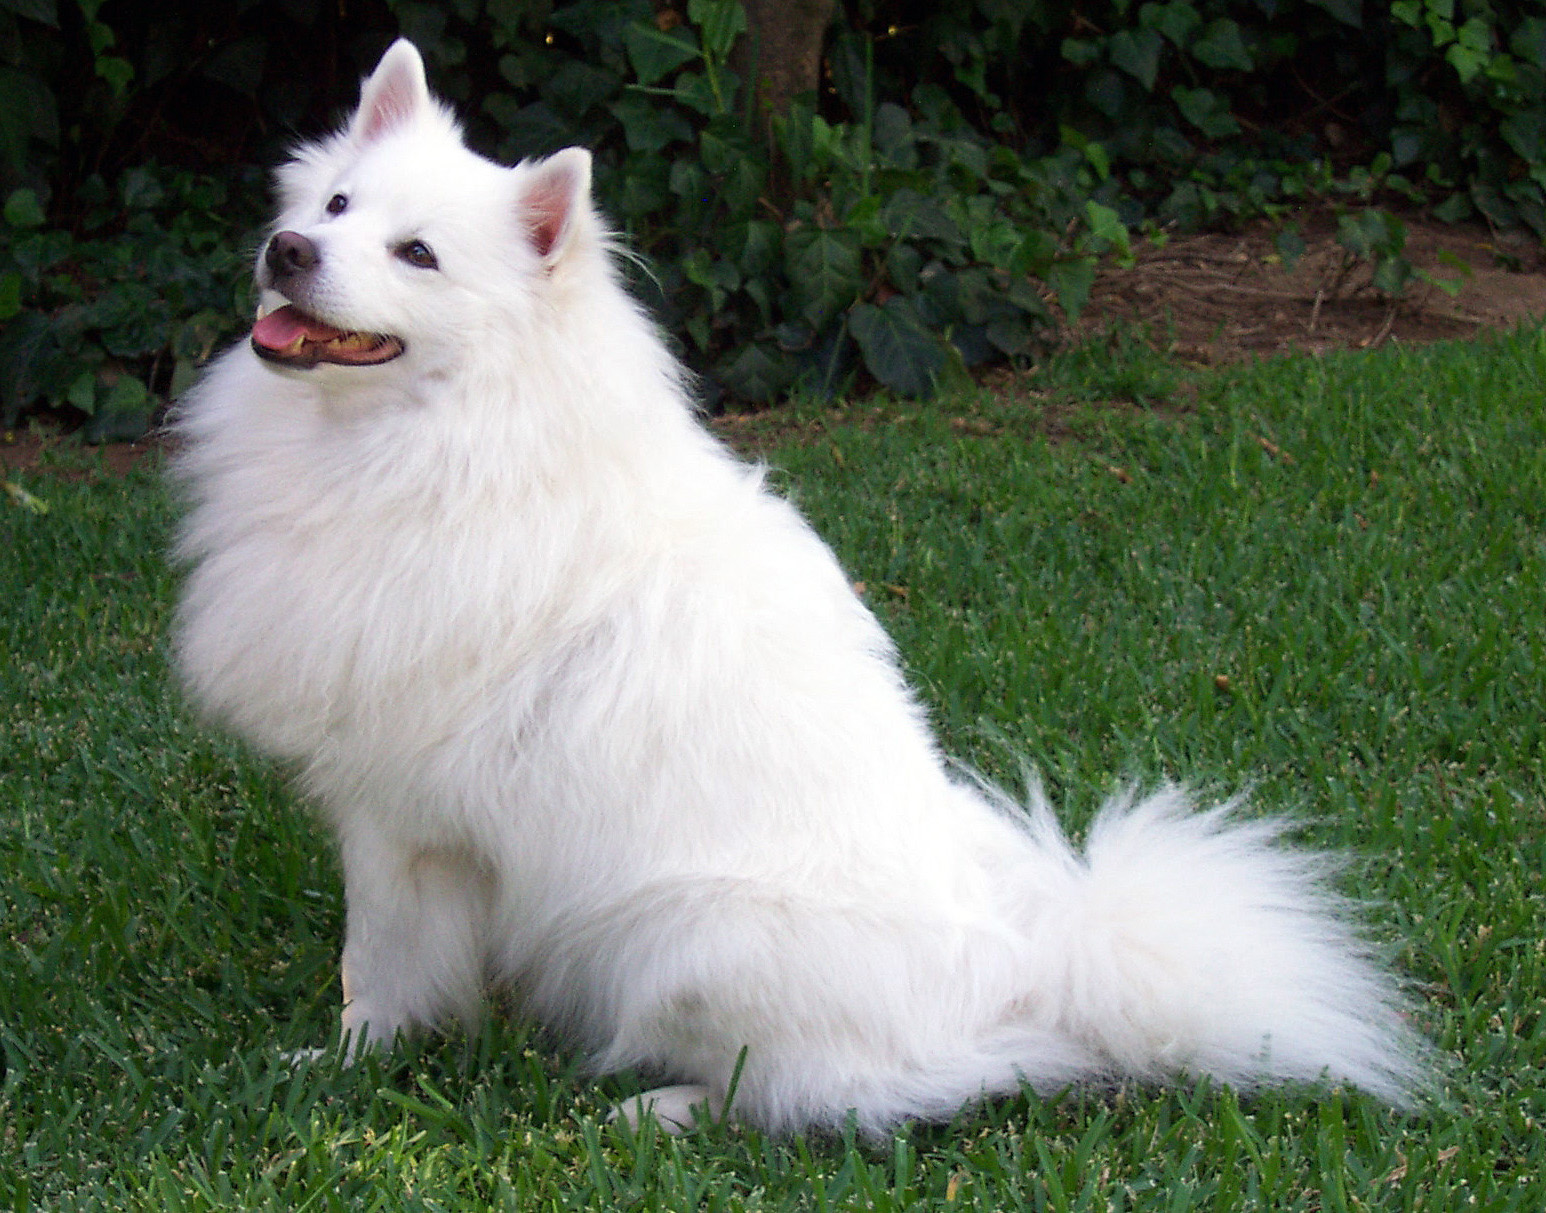

In [ ]:
# Load real image
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dog_input = preprocess(input_image)
dog_input = dog_input.unsqueeze(0)
input_image

### Move model and input to XLA device, inference using XLA backend.

In [ ]:
import os
device = xm.xla_device()
dog_input = dog_input.to(device)
model = model_fp.to(device)
output_fp = model_fp(dog_input)

### Replace the 'fc' layer in ResNet50 with the quantized linear layer.

In [ ]:
# replace the `fc` layer with the weight-only quantized linear layer
setattr(model_fc_int8, 'fc', QuantizedLiner(model_fc_int8.fc))
model_fc_int8 = model_fc_int8.to(device)
output_q = model_fc_int8(dog_input)

### Decode model output using imagenet label txt file

In [ ]:
output_fp = output_fp.cpu()
output_q = output_q.cpu()
probabilities_fp = torch.nn.functional.softmax(output_fp[0], dim=0)
probabilities_q = torch.nn.functional.softmax(output_q[0], dim=0)

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
def show_topk_prediction(probabilities: torch.Tensor, k: int = 5):
    topk_prob, topk_catid = torch.topk(probabilities, k)
    for i in range(topk_prob.size(0)):
      print(categories[topk_catid[i]], topk_prob[i].item())

--2023-08-22 21:27:57--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-08-22 21:27:57 (74.7 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



### ResNet50 model with quantized fully connected layer generated same prediction result

In [ ]:
print("fp32 model top 5 prediction")
show_topk_prediction(probabilities_fp, 3)
print("=========================")
print("int8 fc model top 5 prediction")
show_topk_prediction(probabilities_q, 3)

fp32 model top 5 prediction
Samoyed 0.45537030696868896
white wolf 0.032469768077135086
Pomeranian 0.028255891054868698
int8 fc model top 5 prediction
Samoyed 0.4239707887172699
white wolf 0.03263053670525551
Pomeranian 0.028247928246855736
